In [1]:
import numpy as np
from scipy.signal import iirfilter, lfilter, periodogram, stft

import matplotlib.pyplot as plt
%matplotlib notebook
figsize = [9, 5]

# sampling rate
fs = 10**6
nSamples = 10**6

modFreq = 50
carrierFreq = 225e+3
bandWidth = 25e+3
filtOrd = 2
nHarmonics = 20
filtWn = [(carrierFreq - bandWidth) / (fs / 2), (carrierFreq + bandWidth) / (fs / 2)]

<IPython.core.display.Javascript object>


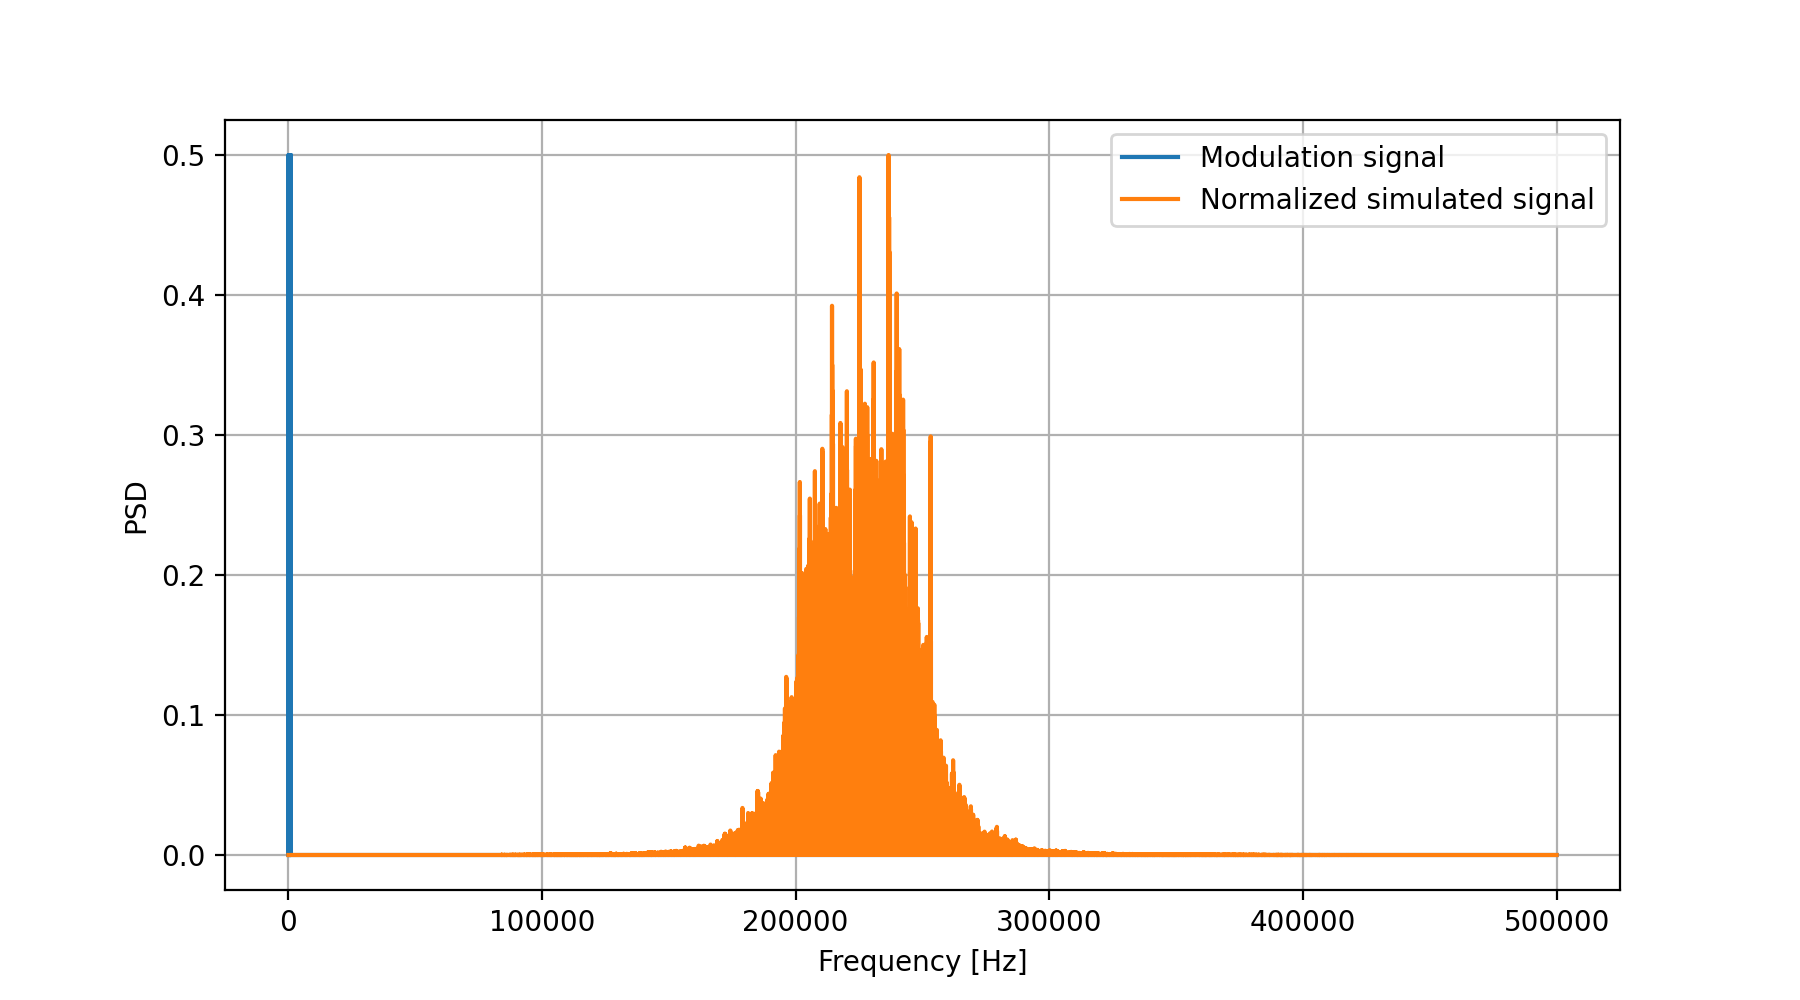

<IPython.core.display.Javascript object>


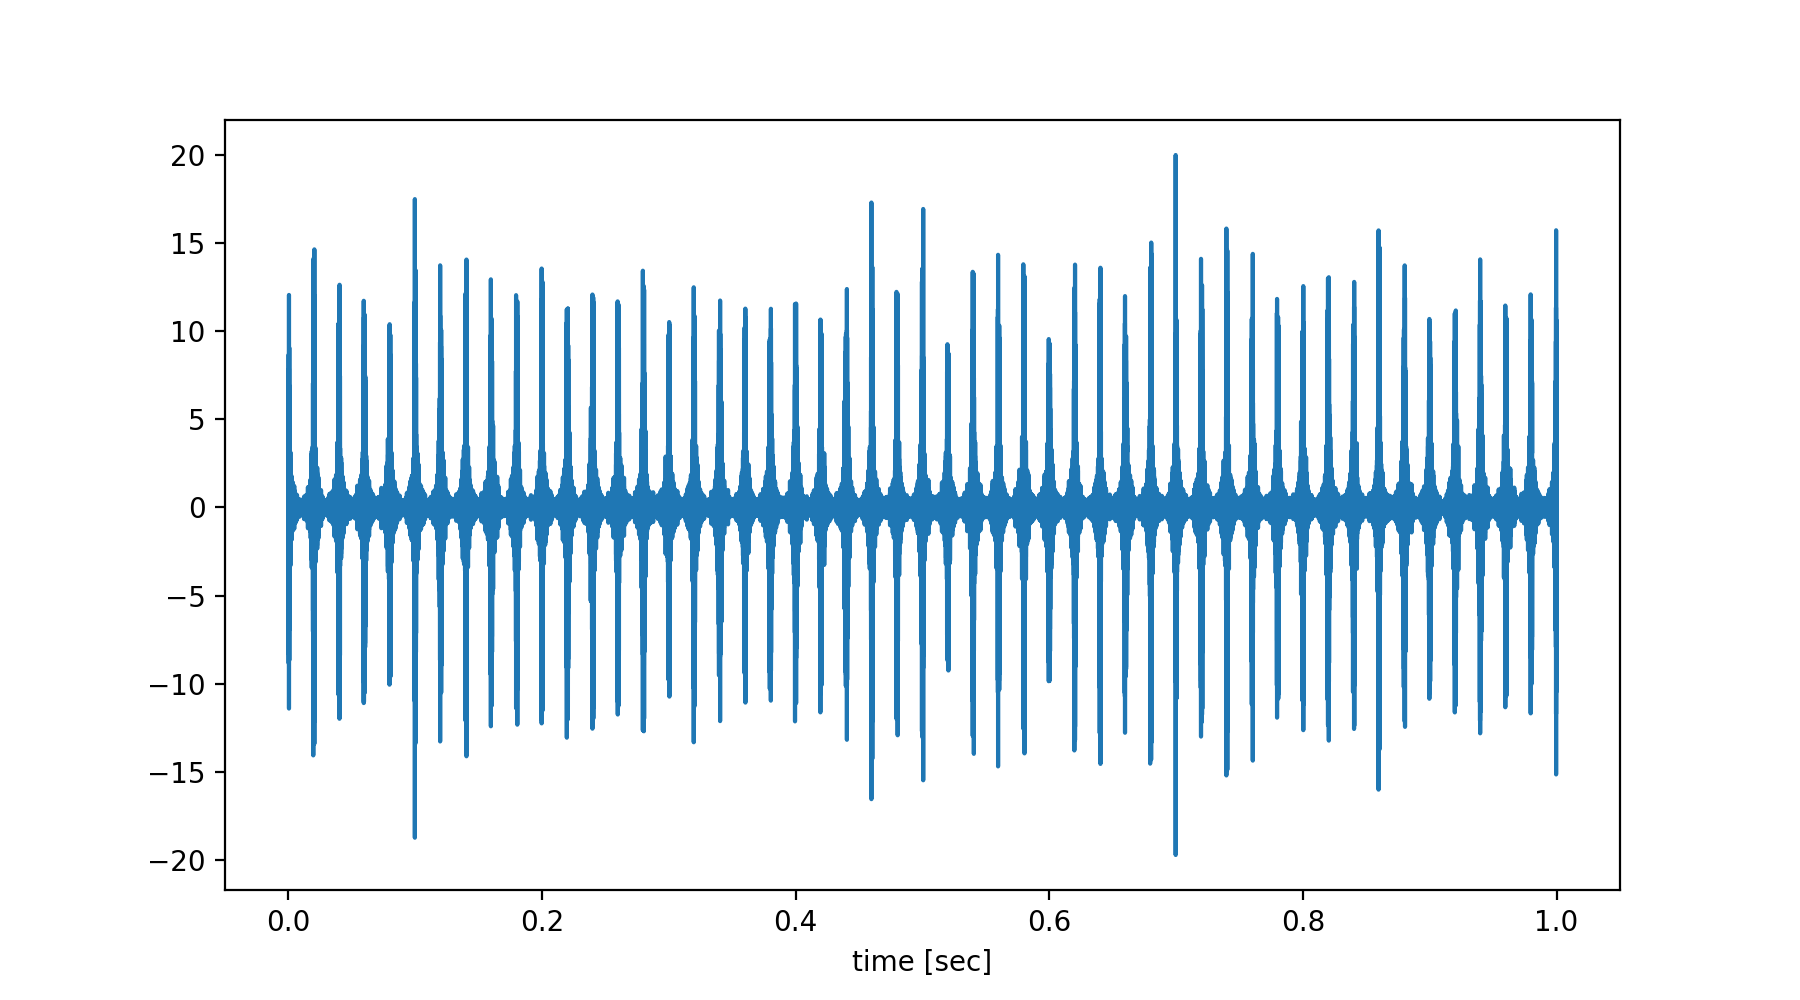

In [2]:
# signal simulation - noise modulating with 100 Hz
t = np.arange(nSamples) / fs

x = np.zeros_like(t)
for h in range(1, nHarmonics):
    x += np.sin(h * modFreq * np.pi * 2 * t) 

plt.figure(figsize=figsize)
f, pxx = periodogram(x, fs)
plt.plot(f, pxx)

x *= np.random.randn(t.shape[0])
b, a = iirfilter(filtOrd, filtWn)
x = lfilter(b, a, x)

f, pxx = periodogram(x, fs)
plt.plot(f, pxx / pxx.max() * 0.5)
plt.grid()
# plt.xlim([0, h * modFreq])
plt.legend(['Modulation signal', 'Normalized simulated signal'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.show()

plt.figure(figsize=[9, 5])
plt.plot(t, x)
plt.xlabel('time [sec]')
plt.show()

In [3]:
# max modulation frequency
alphaMax = 800
# carrier frequency resolution
df = 100
fMin = 50000

# STFT windows' hop
R = int(np.floor(fs / (2 * alphaMax))) #shift of the stft
# STFT window length
Nw = int(fs / df)
# number of STFT windows
M = int((x.size - Nw) / R + 1)

# hannind window
w = np.hanning(Nw)
# Dirichlet kernel parameter
P = int(np.round((Nw - 1) / (2 * R)))
# Dirichlet kernel
D = np.sin((2 * P + 1) * np.pi * (np.arange(Nw) - Nw / 2) / Nw) / np.sin(np.pi * (np.arange(Nw) - Nw / 2) / Nw)
D[int(Nw / 2)] = 2 * P + 1

/var/folders/y7/k3j5759x5qlb_s8xycr9yln80000gq/T/ipykernel_72969/2025358560.py:19: RuntimeWarning: invalid value encountered in true_divide
  D = np.sin((2 * P + 1) * np.pi * (np.arange(Nw) - Nw / 2) / Nw) / np.sin(np.pi * (np.arange(Nw) - Nw / 2) / Nw)


In [4]:
from numpy.lib.stride_tricks import sliding_window_view

# buffering
bufferX = sliding_window_view(x, (Nw, ), )[::R, :]

# x_w
bufferX_w = np.multiply(bufferX, w)
# x_w^P
bufferX_wD = np.multiply(bufferX, w * D)

alpha = np.fft.fftfreq(bufferX.shape[0], R / fs)
f = np.fft.fftfreq(bufferX.shape[1], 1 / fs)

X_w   = np.fft.fft(bufferX_w, axis=1)
x_w_d = np.fft.fft(bufferX_wD, axis=1)

X_w = X_w[:, f >= fMin]
x_w_d = x_w_d[:, f >= fMin]

CS = np.fft.fft(np.conjugate(X_w) * x_w_d, axis=0)
CS = CS[alpha >= 0, :]

CS_CMS = np.fft.fft(np.abs(X_w)**2, axis=0)
CS_CMS = CS_CMS[alpha >= 0, :]

alpha = alpha[alpha >= 0]
f = f[f >= fMin]
# K = np.abs(np.fft.fft((w**2) * D)[:alpha.size])
# CS = np.divide(CS.T, K * fs * M)

<IPython.core.display.Javascript object>


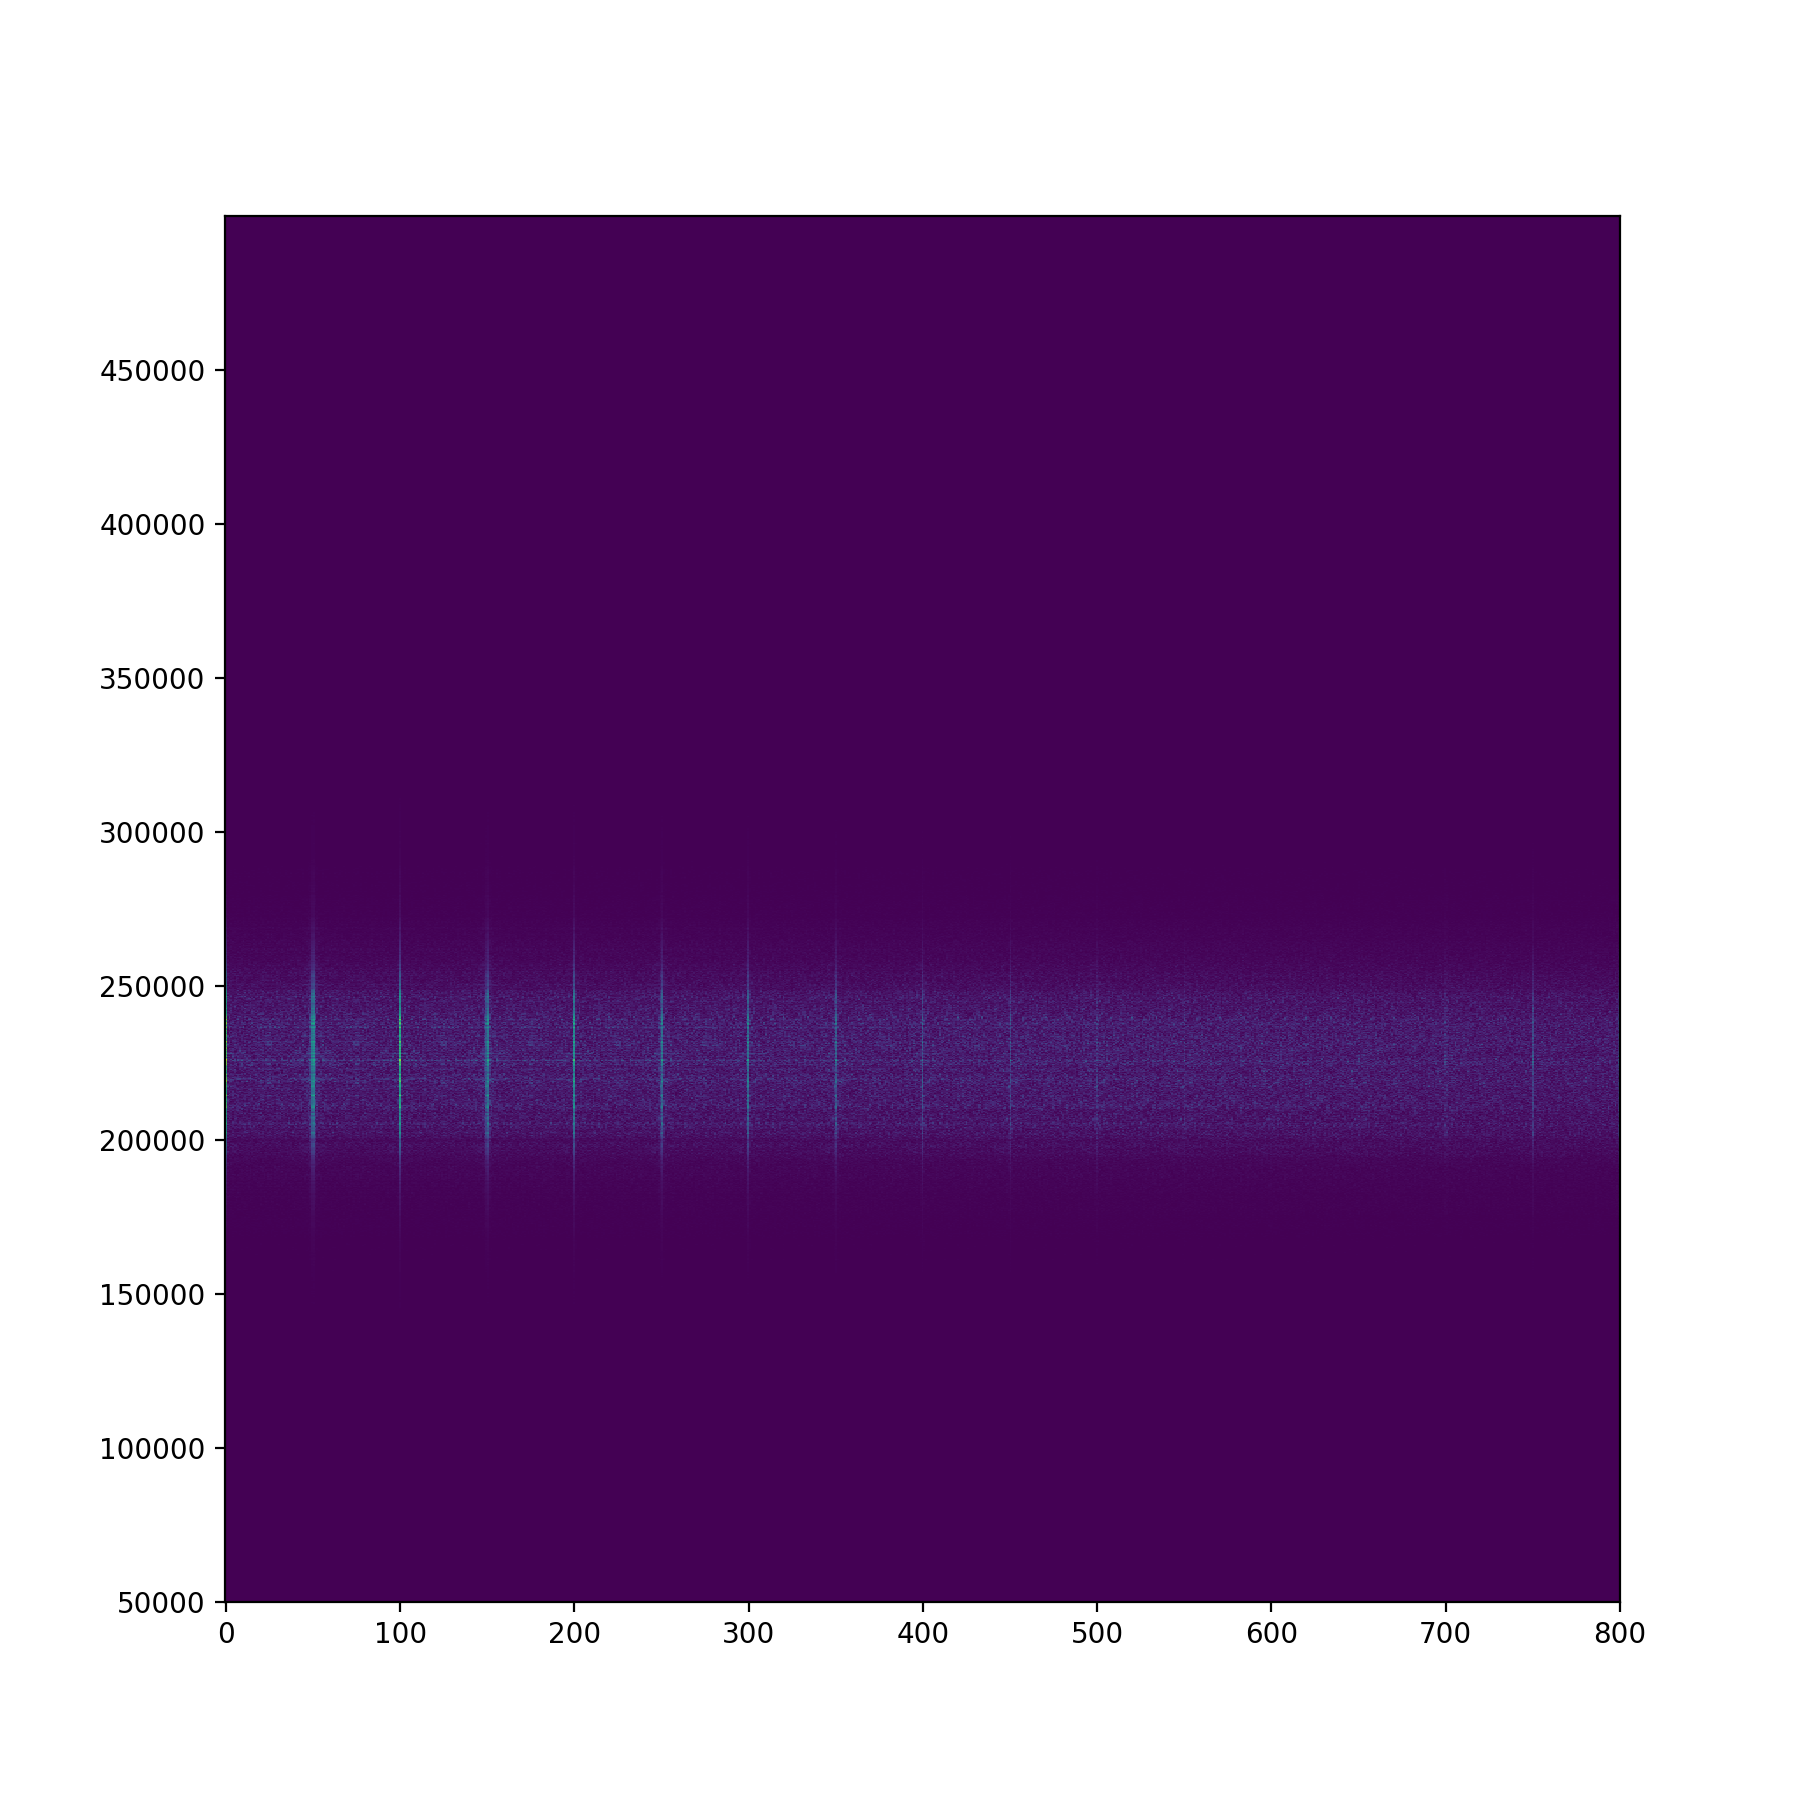

In [5]:
plt.figure(figsize=[9, 9])
plt.pcolormesh(alpha, f, np.abs(CS.T))
plt.show()

<IPython.core.display.Javascript object>


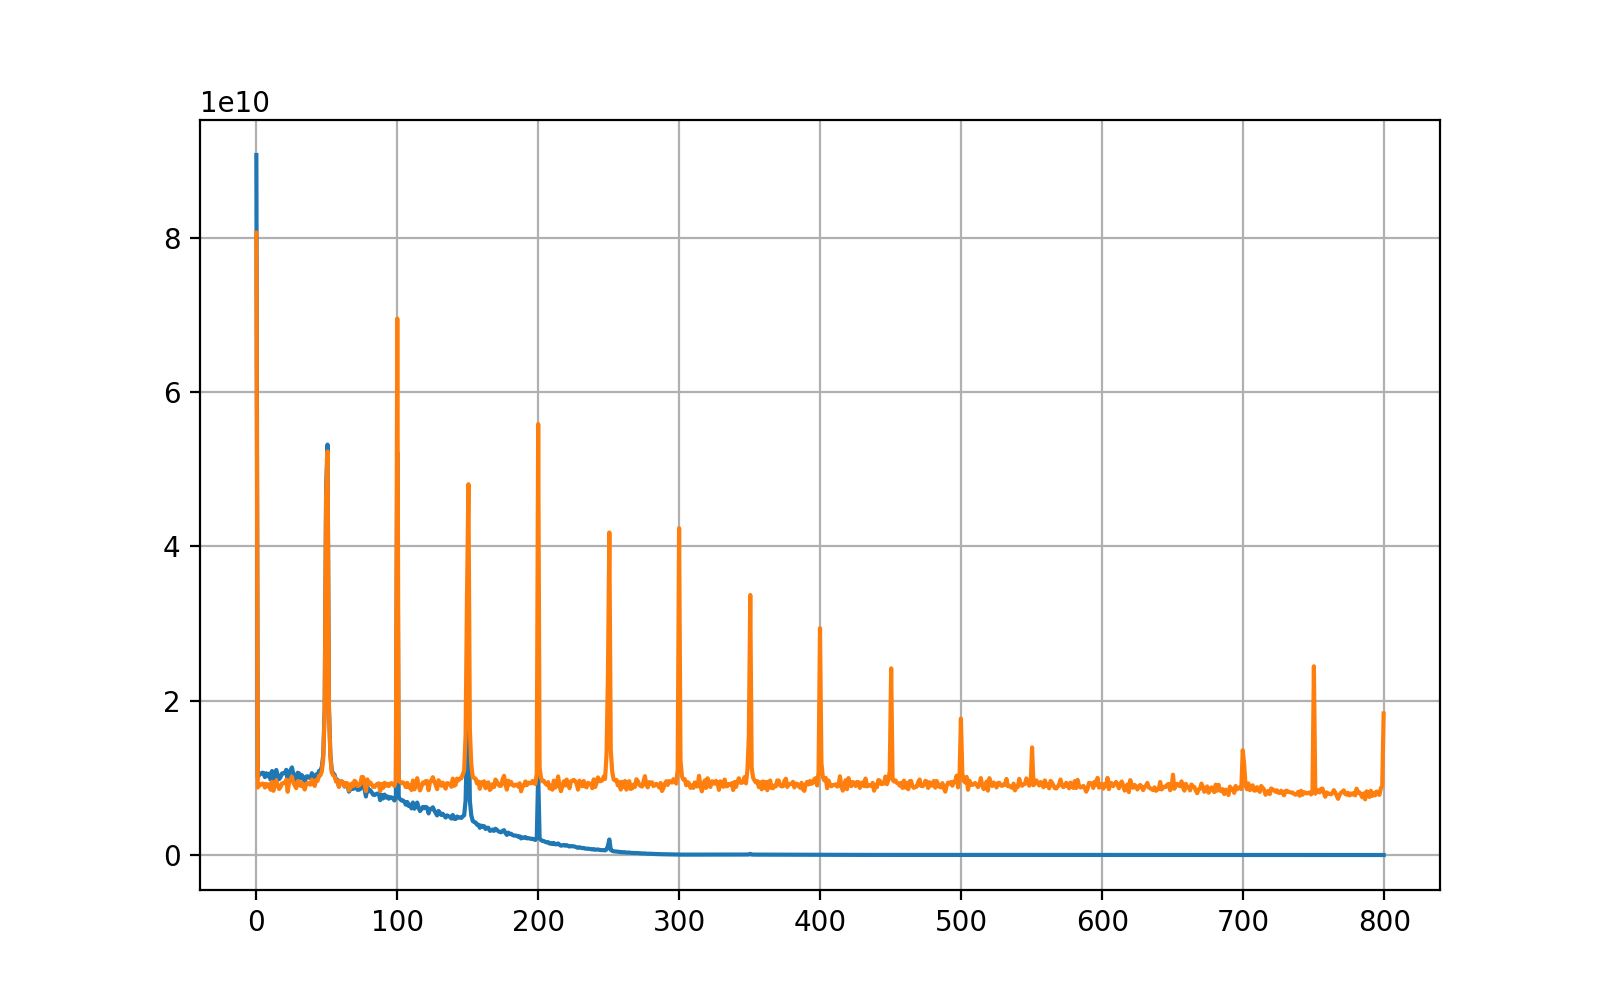

In [6]:
plt.figure(figsize=[8, 5])
plt.plot(alpha, np.sum(np.abs(CS_CMS), axis=1) * 3)
plt.plot(alpha, np.sum(np.abs(CS), axis=1))
plt.grid()
plt.show()